## Introduction

In this example, we implement
[Enhanced Deep Residual Networks for Single Image Super-Resolution (EDSR)](https://arxiv.org/abs/1707.02921)
by Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah, and Kyoung Mu Lee.

The EDSR architecture is based on the SRResNet architecture and consists of multiple
residual blocks. It uses constant scaling layers instead of batch normalization layers to
produce consistent results (input and output have similar distributions, thus
normalizing intermediate features may not be desirable). Instead of using a L2 loss (mean squared error),
the authors employed an L1 loss (mean absolute error), which performs better empirically.

Our implementation only includes 16 residual blocks with 64 channels.

Alternatively, as shown in the Keras example
[Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/#image-superresolution-using-an-efficient-subpixel-cnn),
you can do super-resolution using an ESPCN Model. According to the survey paper, EDSR is one of the top-five
best-performing super-resolution methods based on PSNR scores. However, it has more
parameters and requires more computational power than other approaches.
It has a PSNR value (≈34db) that is slightly higher than ESPCN (≈32db).
As per the survey paper, EDSR performs better than ESPCN.

Paper:
[A comprehensive review of deep learning based single image super-resolution](https://arxiv.org/abs/2102.09351)

Comparison Graph:
<img src="https://dfzljdn9uc3pi.cloudfront.net/2021/cs-621/1/fig-11-2x.jpg" width="500" />

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

## Download the training dataset

We use the DIV2K Dataset, a prominent single-image super-resolution dataset with 1,000
images of scenes with various sorts of degradations,
divided into 800 images for training, 100 images for validation, and 100
images for testing. We use 4x bicubic downsampled images as our "low quality" reference.

In [2]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

## Flip, crop and resize images

In [3]:

def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    hight resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped


## Prepare a `tf.Data.Dataset` object

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 24x24 RGB input patches.

In [4]:

def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

## Visualize the data

Let's visualize a few sample images:

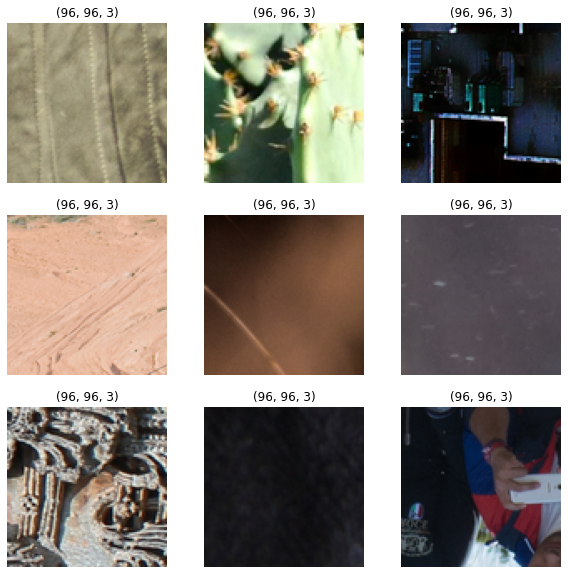

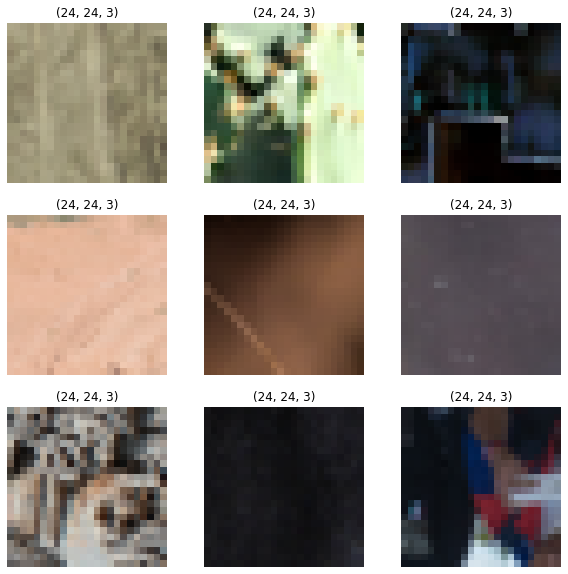

In [5]:
lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


## Build the model

In the paper, the authors train three models: EDSR, MDSR, and a baseline model. In this code example,
we only train the baseline model.

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

In [6]:

class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

## Train the model

In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=500, steps_per_epoch=1, validation_data=val_ds)

Epoch 1/500
1/1 [==============================] - 11s 11s/step - loss: 238.6941 - PSNR: 5.6468 - val_loss: 157.9278 - val_PSNR: 2.3866
Epoch 2/500
1/1 [==============================] - 0s 188ms/step - loss: 140.5289 - PSNR: -1.2584 - val_loss: 110.0350 - val_PSNR: 5.4876
Epoch 3/500
1/1 [==============================] - 0s 198ms/step - loss: 86.9250 - PSNR: 3.5195 - val_loss: 101.1063 - val_PSNR: 6.9892
Epoch 4/500
1/1 [==============================] - 0s 182ms/step - loss: 104.2700 - PSNR: 5.8529 - val_loss: 87.5659 - val_PSNR: 6.8409
Epoch 5/500
1/1 [==============================] - 0s 182ms/step - loss: 89.9446 - PSNR: 5.0876 - val_loss: 79.7179 - val_PSNR: 7.1197
Epoch 6/500
1/1 [==============================] - 0s 176ms/step - loss: 91.9647 - PSNR: 9.0306 - val_loss: 75.0977 - val_PSNR: 8.3000
Epoch 7/500
1/1 [==============================] - 0s 203ms/step - loss: 77.2811 - PSNR: 4.3692 - val_loss: 68.2559 - val_PSNR: 8.3859
Epoch 8/500
1/1 [==============================] 

1/1 [==============================] - 0s 132ms/step - loss: 23.4073 - PSNR: 14.8858 - val_loss: 25.0366 - val_PSNR: 17.2144
Epoch 61/500
1/1 [==============================] - 0s 139ms/step - loss: 20.0065 - PSNR: 24.7085 - val_loss: 23.6388 - val_PSNR: 16.9664
Epoch 62/500
1/1 [==============================] - 0s 135ms/step - loss: 25.4017 - PSNR: 22.4512 - val_loss: 25.1203 - val_PSNR: 16.7890
Epoch 63/500
1/1 [==============================] - 0s 143ms/step - loss: 29.4741 - PSNR: 16.2126 - val_loss: 22.6153 - val_PSNR: 19.7435
Epoch 64/500
1/1 [==============================] - 0s 162ms/step - loss: 29.6486 - PSNR: 20.6638 - val_loss: 24.2003 - val_PSNR: 17.9918
Epoch 65/500
1/1 [==============================] - 0s 165ms/step - loss: 23.7316 - PSNR: 27.0441 - val_loss: 22.6926 - val_PSNR: 18.9497
Epoch 66/500
1/1 [==============================] - 0s 149ms/step - loss: 24.3906 - PSNR: 13.1598 - val_loss: 22.6226 - val_PSNR: 18.7054
Epoch 67/500
1/1 [=============================

1/1 [==============================] - 0s 134ms/step - loss: 15.1833 - PSNR: 20.9410 - val_loss: 17.2007 - val_PSNR: 21.1923
Epoch 120/500
1/1 [==============================] - 0s 133ms/step - loss: 19.0792 - PSNR: 31.1811 - val_loss: 18.2766 - val_PSNR: 20.0072
Epoch 121/500
1/1 [==============================] - 0s 134ms/step - loss: 25.8307 - PSNR: 12.9488 - val_loss: 18.7813 - val_PSNR: 19.6094
Epoch 122/500
1/1 [==============================] - 0s 136ms/step - loss: 21.1485 - PSNR: 16.5366 - val_loss: 18.7578 - val_PSNR: 21.4598
Epoch 123/500
1/1 [==============================] - 0s 133ms/step - loss: 14.3880 - PSNR: 21.7150 - val_loss: 17.6203 - val_PSNR: 19.7570
Epoch 124/500
1/1 [==============================] - 0s 134ms/step - loss: 19.5274 - PSNR: 19.5282 - val_loss: 18.0552 - val_PSNR: 21.9686
Epoch 125/500
1/1 [==============================] - 0s 140ms/step - loss: 15.5290 - PSNR: 16.6425 - val_loss: 17.2061 - val_PSNR: 20.8933
Epoch 126/500
1/1 [======================

1/1 [==============================] - 0s 136ms/step - loss: 17.0310 - PSNR: 17.7477 - val_loss: 15.3263 - val_PSNR: 22.5012
Epoch 179/500
1/1 [==============================] - 0s 135ms/step - loss: 13.0355 - PSNR: 22.5793 - val_loss: 14.3746 - val_PSNR: 23.4738
Epoch 180/500
1/1 [==============================] - 0s 136ms/step - loss: 13.5713 - PSNR: 22.5579 - val_loss: 15.2941 - val_PSNR: 21.4806
Epoch 181/500
1/1 [==============================] - 0s 137ms/step - loss: 17.8010 - PSNR: 23.7433 - val_loss: 14.5573 - val_PSNR: 21.9155
Epoch 182/500
1/1 [==============================] - 0s 144ms/step - loss: 14.2590 - PSNR: 31.6536 - val_loss: 15.7352 - val_PSNR: 21.7938
Epoch 183/500
1/1 [==============================] - 0s 135ms/step - loss: 16.5118 - PSNR: 15.2365 - val_loss: 14.7986 - val_PSNR: 22.6687
Epoch 184/500
1/1 [==============================] - 0s 141ms/step - loss: 18.5833 - PSNR: 21.7730 - val_loss: 14.5354 - val_PSNR: 22.4968
Epoch 185/500
1/1 [======================

1/1 [==============================] - 0s 130ms/step - loss: 14.1632 - PSNR: 18.0644 - val_loss: 12.9778 - val_PSNR: 24.7211
Epoch 238/500
1/1 [==============================] - 0s 132ms/step - loss: 13.0469 - PSNR: 30.7642 - val_loss: 13.6142 - val_PSNR: 24.0907
Epoch 239/500
1/1 [==============================] - 0s 137ms/step - loss: 13.4754 - PSNR: 20.5540 - val_loss: 13.1410 - val_PSNR: 24.3617
Epoch 240/500
1/1 [==============================] - 0s 138ms/step - loss: 14.1489 - PSNR: 23.3956 - val_loss: 13.4282 - val_PSNR: 23.9836
Epoch 241/500
1/1 [==============================] - 0s 136ms/step - loss: 14.6605 - PSNR: 26.0509 - val_loss: 12.9934 - val_PSNR: 22.9982
Epoch 242/500
1/1 [==============================] - 0s 142ms/step - loss: 16.7271 - PSNR: 16.0836 - val_loss: 14.6691 - val_PSNR: 21.1568
Epoch 243/500
1/1 [==============================] - 0s 132ms/step - loss: 14.6176 - PSNR: 18.9677 - val_loss: 13.1677 - val_PSNR: 23.4442
Epoch 244/500
1/1 [======================

1/1 [==============================] - 0s 144ms/step - loss: 14.5191 - PSNR: 21.2166 - val_loss: 11.8657 - val_PSNR: 23.5222
Epoch 297/500
1/1 [==============================] - 0s 140ms/step - loss: 8.9058 - PSNR: 25.0103 - val_loss: 12.6703 - val_PSNR: 25.7736
Epoch 298/500
1/1 [==============================] - 0s 135ms/step - loss: 12.3963 - PSNR: 23.7132 - val_loss: 12.5718 - val_PSNR: 26.1191
Epoch 299/500
1/1 [==============================] - 0s 138ms/step - loss: 10.1056 - PSNR: 35.6100 - val_loss: 13.3736 - val_PSNR: 25.0448
Epoch 300/500
1/1 [==============================] - 0s 135ms/step - loss: 11.2050 - PSNR: 22.9534 - val_loss: 13.2393 - val_PSNR: 23.2841
Epoch 301/500
1/1 [==============================] - 0s 133ms/step - loss: 13.3637 - PSNR: 19.8781 - val_loss: 12.7934 - val_PSNR: 24.5241
Epoch 302/500
1/1 [==============================] - 0s 135ms/step - loss: 10.9865 - PSNR: 29.3400 - val_loss: 12.1359 - val_PSNR: 23.6959
Epoch 303/500
1/1 [=======================

1/1 [==============================] - 0s 133ms/step - loss: 8.3108 - PSNR: 26.9790 - val_loss: 12.5402 - val_PSNR: 24.0837
Epoch 356/500
1/1 [==============================] - 0s 133ms/step - loss: 11.1908 - PSNR: 27.8183 - val_loss: 11.4926 - val_PSNR: 25.6636
Epoch 357/500
1/1 [==============================] - 0s 136ms/step - loss: 15.3055 - PSNR: 28.5880 - val_loss: 12.3468 - val_PSNR: 23.2396
Epoch 358/500
1/1 [==============================] - 0s 132ms/step - loss: 16.7671 - PSNR: 19.4920 - val_loss: 12.5598 - val_PSNR: 24.5828
Epoch 359/500
1/1 [==============================] - 0s 140ms/step - loss: 13.7619 - PSNR: 17.4317 - val_loss: 12.3633 - val_PSNR: 22.9397
Epoch 360/500
1/1 [==============================] - 0s 134ms/step - loss: 12.0055 - PSNR: 25.8233 - val_loss: 11.8749 - val_PSNR: 27.2736
Epoch 361/500
1/1 [==============================] - 0s 137ms/step - loss: 10.0240 - PSNR: 35.3819 - val_loss: 11.7642 - val_PSNR: 25.5032
Epoch 362/500
1/1 [=======================

1/1 [==============================] - 0s 140ms/step - loss: 10.0438 - PSNR: 31.9276 - val_loss: 11.1899 - val_PSNR: 23.3902
Epoch 415/500
1/1 [==============================] - 0s 135ms/step - loss: 12.5506 - PSNR: 22.3621 - val_loss: 12.1173 - val_PSNR: 25.9484
Epoch 416/500
1/1 [==============================] - 0s 137ms/step - loss: 13.1636 - PSNR: 15.1182 - val_loss: 11.4532 - val_PSNR: 24.6497
Epoch 417/500
1/1 [==============================] - 0s 141ms/step - loss: 12.7175 - PSNR: 23.2140 - val_loss: 10.6345 - val_PSNR: 27.2011
Epoch 418/500
1/1 [==============================] - 0s 136ms/step - loss: 12.8668 - PSNR: 24.2130 - val_loss: 11.2126 - val_PSNR: 25.1190
Epoch 419/500
1/1 [==============================] - 0s 136ms/step - loss: 9.4932 - PSNR: 22.6747 - val_loss: 11.6770 - val_PSNR: 23.2855
Epoch 420/500
1/1 [==============================] - 0s 139ms/step - loss: 12.2173 - PSNR: 19.1848 - val_loss: 12.2193 - val_PSNR: 26.0084
Epoch 421/500
1/1 [=======================

## Run inference on new images and plot the results

In [ ]:

def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)

## Final remarks

In this example, we implemented the EDSR model (Enhanced Deep Residual Networks for Single Image
Super-Resolution). You could improve the model accuracy by training the model for more epochs, as well as
training the model with a wider variety of inputs with mixed downgrading factors, so as to
be able to handle a greater range of real-world images.

You could also improve on the given basline EDSR model by implementing EDSR+,
or MDSR( Multi-Scale super-resolution) and MDSR+,
which were proposed in the same paper.